In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
# import torch
import numpy as np

# import nltk

import transformers
from datasets import load_dataset
# import evaluate

In [4]:
dataset = '/content/drive/MyDrive/Colab Notebooks/summarization/indonesian_test.csv'

In [5]:
import pandas as pd
df = pd.read_csv(dataset)
df.head()

,id,url,title,summary,text
0,141105_seni_vangogh,https://www.bbc.com/indonesia/majalah/2014/11/...,"Lukisan bunga Van Gogh terjual US$61,8 juta","Sebuah mahakarya Vincent van Gogh, yang diluki...","Still Life, Vase with Daisies, and Poppies dib..."
1,dunia-49410599,https://www.bbc.com/indonesia/dunia-49410599,Mengapa pengungsi Suriah diminta segera mening...,Ribuan pengungsi Suriah punya waktu hingga Sel...,Foto tanggal 6 Agustus ini memperlihatkan kelu...
2,trensosial-38156839,https://www.bbc.com/indonesia/trensosial-38156839,Para pemain Chapecoense akan dikenang selamany...,"Ribuan orang berkumpul di kota Chapeco, Brasil...",Para keluarga korban berada di tengah fan yang...
3,160317_dunia_turki_kurdi_serangan,https://www.bbc.com/indonesia/dunia/2016/03/16...,Kelompok Kurdi TAK klaim mengebom Ankara,Kelompok militan Kurdi TAK mengatakan pihaknya...,Disebutkan oleh TAK bahwa korban sipil tak bis...
4,dunia-52171474,https://www.bbc.com/indonesia/dunia-52171474,Virus corona: Sejumlah dokter di India ‘diluda...,Sejumlah tenaga kesehatan di India dilaporkan ...,Para dokter di India bekerja lembur untuk meng...


In [6]:
from datasets import Dataset

# Memuat dataset
dataset = Dataset.from_pandas(df)

# Split dataset menjadi train dan test
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_val_dataset = split_dataset['train']
test_dataset = split_dataset['test']  # Ini hanya untuk pengujian akhir

# Split train_val_dataset menjadi train dan validation
split_train_val = train_val_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_train_val['train']
eval_dataset = split_train_val['test']

# Tampilkan beberapa contoh
print("Training dataset:")
print(train_dataset)
print("\nEval dataset:")
print(eval_dataset)
print("\nTesting dataset:")
print(test_dataset)

Training dataset:
Dataset({
    features: ['id', 'url', 'title', 'summary', 'text'],
    num_rows: 3871
})

Eval dataset:
Dataset({
    features: ['id', 'url', 'title', 'summary', 'text'],
    num_rows: 431
})

Testing dataset:
Dataset({
    features: ['id', 'url', 'title', 'summary', 'text'],
    num_rows: 478
})


In [36]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained('Wikidepia/IndoT5-small')

In [37]:
def preprocess_function(examples):
    # Tokenisasi input
    model_inputs = tokenizer(
        examples['text'], max_length=512, truncation=True, padding="max_length"
    )
    # Tokenisasi target
    labels = tokenizer(
        examples['summary'], max_length=128, truncation=True, padding="max_length"
    )
    # Menambahkan labels ke dalam model_inputs
    model_inputs['labels'] = labels['input_ids']
    return model_inputs


In [38]:
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

# Tampilkan beberapa contoh hasil tokenisasi
print(tokenized_train_dataset)
print(tokenized_eval_dataset)
print(tokenized_test_dataset)

Map:   0%|          | 0/3871 [00:00<?, ? examples/s]

Map:   0%|          | 0/431 [00:00<?, ? examples/s]

Map:   0%|          | 0/478 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'url', 'title', 'summary', 'text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 3871
})
Dataset({
    features: ['id', 'url', 'title', 'summary', 'text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 431
})
Dataset({
    features: ['id', 'url', 'title', 'summary', 'text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 478
})


In [39]:
print(tokenized_train_dataset[0])

{'id': 'indonesia-39076611', 'url': 'https://www.bbc.com/indonesia/indonesia-39076611', 'title': 'Masjid disegel, jemaah Ahmadiyah Depok salat Jumat di pelataran', 'summary': 'Masjid Ahmadiyah di Depok disegel Pemda, sejumlah kecil jamaah Ahmadiyah melakukan salat Jumat di pelataran, kendati didesak untuk tak melakukannya, dan mendapat ancaman.', 'text': 'Walikota Depok mengatakan, penyegelan dilakukan dengan pertimbangan situasi keamanan karena ada protes dari masyarakat tertentu. Penyegelan Masjid Al-Hidayah milik Jemaat Ahmadiyah Sawangan dilakukan oleh Satpol PP Kota Depok, Kamis (23/2). Mubaligh Jamaah Ahmadiyah Indonesia (JAI) Depok, Farid Mahfud mengatakan, sehari sesudah penyegelan, mereka mendapat ancaman aksi massa, dan diminta oleh polisi untuk untuk tidak melakukan salat Jumat di sana. Kepolisian membantahnya. "Siapa bilang kami melarang salat Jumat? Kami tidak pernah melarang ibadah, apa pun kepercayaan mereka," kata Kapolres Depok, AKBP Herry Heryawan kepada Ging Ginanjar

In [40]:
from transformers import DataCollatorWithPadding, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments, T5ForConditionalGeneration
model = T5ForConditionalGeneration.from_pretrained('Wikidepia/IndoT5-small')

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

pytorch_model.bin:   0%|          | 0.00/308M [00:00<?, ?B/s]

In [41]:
# Parameter
learning_rate = 1e-5  # Laju pembelajaran
train_batch_size = 4    # Ukuran batch untuk pelatihan
epochs = 5             # Jumlah epoch
weight_decay = 0.01      # Pengurangan bobot

# Direktori untuk menyimpan hasil
output_directory = f'./results_mt5_{learning_rate}_{train_batch_size}_{epochs}'

In [42]:
from transformers import TrainingArguments

# Define arguments of the finetuning
training_args = TrainingArguments(
    output_dir = output_directory,          # direktori untuk menyimpan model
    evaluation_strategy="epoch",     # evaluasi setiap epoch
    learning_rate=learning_rate,
    per_device_train_batch_size=train_batch_size,   # ukuran batch untuk pelatihan
    num_train_epochs=epochs,              # jumlah epoch
    weight_decay=weight_decay,
    # report_to="none"  # Nonaktifkan pelacakan otomatis
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [43]:
from transformers import Trainer, DataCollatorForSeq2Seq

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
)

In [44]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,43.386100,4.549561
2,3.586100,1.484439
3,1.489400,0.816413
4,0.952400,0.723231
5,0.848300,0.708136


TrainOutput(global_step=4840, training_loss=7.842593024387832, metrics={'train_runtime': 1363.3144, 'train_samples_per_second': 14.197, 'train_steps_per_second': 3.55, 'total_flos': 3597910718545920.0, 'train_loss': 7.842593024387832, 'epoch': 5.0})

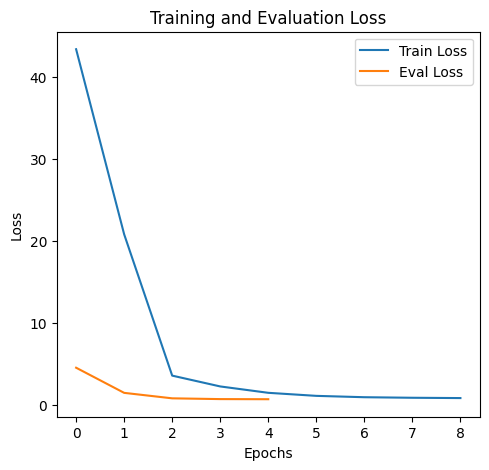

In [45]:
import matplotlib.pyplot as plt
# Mengambil data dari log
train_logs = trainer.state.log_history

# Membuat list untuk loss dan accuracy
train_loss = []
eval_loss = []

for log in train_logs:
    if 'loss' in log:
        train_loss.append(log['loss'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])

# Plotting
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(len(train_loss)), train_loss, label="Train Loss")
plt.plot(range(len(eval_loss)), eval_loss, label="Eval Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()

# Tampilkan plot
plt.show()

In [46]:
new_article = test_dataset[1]["text"]
new_summary = test_dataset[1]["summary"]
print(new_article)
print(new_summary)

Murray unggul dalam 8 pertandingan dengan Lopez Petenis Inggris itu sudah delapan kali bertemu Lopez dan menang di semua pertandingan. Kini dengan disaksikan mantan pelatihnya Ivan Lendl, ia mencetak kemenangan kesembilan. Murray mengalahkan Lopez, unggulan ke-32, dengan 6-4 6-1 dalam waktu 73 menit. Di babak berikutnya ia akan bertemu dengan unggulan ke-11 Jo-Wilfried Tsonga. Sementara itu Roger Federer mengalahkan petenis Belanda Thiemo de Bakker dengan 6-3 6-3. Murray menunjukkan performa kuat di hadapan Lendl, yang hanya empat hari setelah pengumuman perpisahan mereka, terbang tiga jam dari Florida ke Miami untuk melihat petenis yang telah ia bantu menjuarai Olimpiade, AS Terbuka dan Wimbledon. "Kami kembali bersama. Kami hanya berpisah selama empat hari," kelakar Murray. "Tidak, sayang sekali ia tidak akan lagi menyaksikan pertandingan saya secara langsung."
Juara bertahan Andy Murray mengalahkan petenis Spanyol Feliciano Lopez dua set langsung dan lolos ke babak keempat turnamen 

In [48]:
tokenizer_result_mt5 = T5Tokenizer.from_pretrained('Wikidepia/IndoT5-small')
model_result_mt5 = T5ForConditionalGeneration.from_pretrained('/content/results_mt5_1e-05_4_5/checkpoint-4840')

# Teks input
input_text = new_article
input_teks = input_text
input_ids = tokenizer_result_mt5.encode(input_teks, return_tensors='pt')

# Menghasilkan ringkasan
output_ids = model_result_mt5.generate(input_ids, max_length=70)
output_text = tokenizer_result_mt5.decode(output_ids[0], skip_special_tokens=True)

# print("Referensi: ", referensi_ringkasan)
print("Ringkasan Hasil Fine Tune:", output_text)

Ringkasan Hasil Fine Tune: Murray Murray unggul dalam 8 pertandingan dengan petenis Inggris, Roger Federer, dan petenis Inggris, Roger Federer.


In [49]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
# Calculate BLEU score for this sentence
bleu_score = sentence_bleu([new_summary], output_text)

# Print the results
print(f"Input: {new_article}")
print(f"Predicted: {output_text}")
print(f"Reference: {new_summary}")
print(f"BLEU Score: {bleu_score:.4f}")
print("-" * 50)

Input: Murray unggul dalam 8 pertandingan dengan Lopez Petenis Inggris itu sudah delapan kali bertemu Lopez dan menang di semua pertandingan. Kini dengan disaksikan mantan pelatihnya Ivan Lendl, ia mencetak kemenangan kesembilan. Murray mengalahkan Lopez, unggulan ke-32, dengan 6-4 6-1 dalam waktu 73 menit. Di babak berikutnya ia akan bertemu dengan unggulan ke-11 Jo-Wilfried Tsonga. Sementara itu Roger Federer mengalahkan petenis Belanda Thiemo de Bakker dengan 6-3 6-3. Murray menunjukkan performa kuat di hadapan Lendl, yang hanya empat hari setelah pengumuman perpisahan mereka, terbang tiga jam dari Florida ke Miami untuk melihat petenis yang telah ia bantu menjuarai Olimpiade, AS Terbuka dan Wimbledon. "Kami kembali bersama. Kami hanya berpisah selama empat hari," kelakar Murray. "Tidak, sayang sekali ia tidak akan lagi menyaksikan pertandingan saya secara langsung."
Predicted: Murray Murray unggul dalam 8 pertandingan dengan petenis Inggris, Roger Federer, dan petenis Inggris, Roge

In [50]:
from nltk.translate.bleu_score import sentence_bleu
# List untuk menyimpan skor BLEU
bleu_scores = []

# Pastikan `test_dataset` memiliki 10 data
for i in range(10):
    # Teks input dari dataset
    new_article = test_dataset[i]["text"]  # Pastikan `document` adalah kunci yang benar

    # Tokenisasi
    input_teks = new_article
    input_ids = tokenizer_result_mt5.encode(input_teks, return_tensors='pt')

    # Menghasilkan ringkasan
    output_ids = model_result_mt5.generate(input_ids, max_length=70)
    output_text = tokenizer_result_mt5.decode(output_ids[0], skip_special_tokens=True)

    # Hitung BLEU score
    bleu_score = sentence_bleu([test_dataset[i]["summary"]], output_text)  # `hypothesis` diubah menjadi list of words
    bleu_scores.append(bleu_score)

    # Cetak hasil setiap iterasi
    print(f"Input: {new_article}")
    print(f"Predicted: {output_text}")
    print(f"Reference: {test_dataset[i]['summary']}")
    print(f"BLEU Score: {bleu_score:.4f}")
    print("-" * 50)

# Hitung rata-rata BLEU score
average_bleu_score = sum(bleu_scores) / len(bleu_scores)

# Cetak rata-rata BLEU score
print(f"Average BLEU Score for 10 samples: {average_bleu_score:.4f}")

Input: Pandemi Covid-19 telah meningkatkan minat berinvestasi emas. Kenaikan harga itu salah satu penyebab utamanya karena permainan para pedagang emas dan permintaan yang tinggi, tapi di balik itu, muncul pertanyaan tentang berapa sisa pasokan logam mulia itu di bumi dan kapan akan habis. Emas menjadi buruan masyarakat karena dapat dijadikan sebagai investasi, simbol status ekonomi, dan komponen utama produk elektronik. Tapi jumlah emas di dunia terbatas, dan pada akhirnya akan datang satu saat ketika tidak ada lagi emas yang tersisa untuk ditambang. Puncak produksi emas Beberapa ahli berbicara tentang apakah dunia telah mencapai puncak produksi emas - diukur dengan jumlah terbanyak emas yang pernah ditambang dalam satu tahun - atau tidak. Hal itu ditunjukan dengan mulai menurunnya tren produksi emas dunia. Contohnya, pada tahun 2019, produksi tambang emas dunia turun 1% menjadi 3.531 ton dibandingkan tahun 2018, menurut Dewan Emas Dunia. Penurunan produksi tahunan ini yang pertama se